In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expi
from sklearn.metrics import mean_squared_error


In [151]:
import os
os.chdir(r"C:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC")
import numpy as np
from src.modules.model_class import Model


class SINGLE_DISPERSION(Model):
    """
    The single dispersion model assumes the flow through the system follows 
    a single flow path that can be represented by laminar/plug flow overlayed 
    with some dispersion. The concentration curves are then added together to 
    predict the output concentration. 

    Attributes:
    - dt : the amount of time during which the tracer was injected (CFD sim dt)
    - tau : the spacetime of the reactor defined by volume / flow rate
    - bounds : the bounds for the model parameters which are optimized for
    - C0 : initial concnetration CALCULATED BY N0 / TOTAL REACTOR MASS

    """

    def __init__(self, dt, tau, bounds=None, initial_guess=None, C0=1):
        """
        Initializes the model 

        Parameters: 
        - See class level doc string
        """

        super().__init__(initial_guess=initial_guess)
        self.dt = dt
        self.tau = tau
        self.bounds = bounds
        self.C0 = (self.dt * (4*10**-6)) / (1.94*10**-7)
    
    def C_1(self, t: float, Pe: float, tau: float) -> np.array:
        """
        Taylor-Dispersion superimposed on a laminar/plug flow. 

        Parameters:
        - t : time
        - Pe : radial peclet number of the system
        - tau : spacetime of flow path 1

        Returns:
        - np.array that gives concentration predictions for each time stamp
        """
        term_1 = 1 / 2 / np.sqrt(np.pi*(t/tau)/Pe)
        term_2 = np.exp(-1 * (1-(t/tau))**2 * Pe / 4 / (t/tau))        
        return np.where(t==0, 0, self.C0 * term_1 * term_2)

    
    def function(self, x, Pe, tau):
        """
        Sums the concentration profiles for flow path 1 and flow path 2.
        """
        return self.C_1(x, Pe, tau) 

In [152]:
class LFR_DZ_CSTR():
    """
    LFR_DZ_CSTR model represents a system where all flow first enters a 
    laminar flow reactor (LFR).The outlet of the LFR goes directly to the 
    CSTR. The model has two primary parameters:
    - a : the fraction of real volume that is described by the LFR
    - b : the fraction of real volume that is described by the CSTR

    Attributes:
    - dt : the amount of time during which the tracer was injected (CFD sim dt)
    - tau : the spacetime of the reactor defined by volume / flow rate
    - bounds : the bounds for the model parameters which are optimized for
    - C0 : initial concnetration injected in pulse experiment

    Notes: 
    - This is currently the best model for Phase I of Miller's dissertation
    - A third parameter that is not a degree of freedom, call it c, is found by
      subtracting the sum of a and b from 1. This is representative of the 
      fraction of the volume represented as a stagnant or deadzone. 
    """

    def __init__(self, dt, tau, bounds=None, initial_guess=None, C0=1):
        """
        Initializes the model 

        Parameters: 
        - See class level doc string
        """
        self.dt = dt
        self.tau = tau
        self.bounds = bounds
        self.C0 = C0
    

    def exp_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return np.exp(m*t)*(m*t + 1)/t**2

    def expi_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return m**2 * expi(m*t)

    def outlet_concentration(self, t, a, b):
        """
        Calculates the concentration leaving the CSTR for some time, t

        Parameters:
        - a : the fraction of volume given by the LFR
        - b : the fraction of volume given by the CSTR

        Returns:
        - The concentration leaving the CSTR at time t

        """

        tau_LFR = a*self.tau
        tau_CSTR = b*self.tau

        m = 1 / tau_CSTR
        n = tau_LFR**2 * self.C0 * self.dt / 2 / tau_CSTR
        C_0 = 0
        C_IC = n*0.5*(self.exp_term(tau_LFR/2, m) - self.expi_term(tau_LFR/2, m))
        C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
        C_CSTR_out = np.where(t < tau_LFR/2, C_0, C_1)
        return C_CSTR_out
    
    def function(self, xdata, a, b):
        return self.outlet_concentration(xdata, a, b)

In [153]:
model = LFR_DZ_CSTR(0.000192, .6770090/1.5)

t = np.linspace(0, 5, 500)

param_dict = {'Set1': [0.7, 0.25], 'Set2': [0.5, 0.25], 'Set3': [0.3, 0.25],
              'Set4': [0.5, 0.05], 'Set5': [0.5, 0.25], 'Set6': [0.5, 0.45]}

c1 = model.outlet_concentration(t, *param_dict['Set1'])
c2 = model.outlet_concentration(t, *param_dict['Set2'])
c3 = model.outlet_concentration(t, *param_dict['Set3'])

c4 = model.outlet_concentration(t, *param_dict['Set4'])
c5 = model.outlet_concentration(t, *param_dict['Set5'])
c6 = model.outlet_concentration(t, *param_dict['Set6'])

C:\Users\jacob\AppData\Local\Temp\ipykernel_26340\2107740481.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2


In [206]:
import math
def TIS(xdata, n):
    tau = 0.047565295
    numerator = xdata**(n-1)
    denominator = math.gamma(n)*(tau/n)**n
    N0 = 1e-6 * (1045 * 4*10**-6)
    return N0*(numerator/denominator)*np.exp(-xdata / (tau/n)) / (1045*4.0e-6)

[1.25703456 0.07764704]
[5.23398827e+01 4.07020650e-02]
[13.74749387]


C:\Users\jacob\AppData\Local\Temp\ipykernel_26340\2135255559.py:48: RuntimeWarning: divide by zero encountered in divide
  term_1 = 1 / 2 / np.sqrt(np.pi*(t/tau)/Pe)
C:\Users\jacob\AppData\Local\Temp\ipykernel_26340\2135255559.py:49: RuntimeWarning: divide by zero encountered in divide
  term_2 = np.exp(-1 * (1-(t/tau))**2 * Pe / 4 / (t/tau))
C:\Users\jacob\AppData\Local\Temp\ipykernel_26340\2135255559.py:50: RuntimeWarning: invalid value encountered in multiply
  return np.where(t==0, 0, self.C0 * term_1 * term_2)


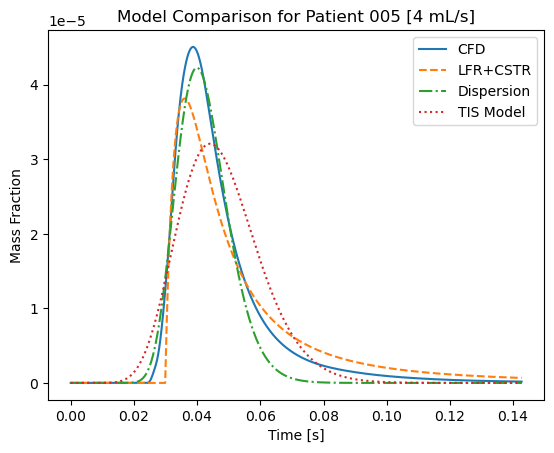

In [212]:
from scipy.optimize import curve_fit

pat_model = LFR_DZ_CSTR(1e-6, 0.047565295)
SD = SINGLE_DISPERSION(1e-6, 0.047565295)

patient_005 = pd.read_csv("data/C_curves/sim6.csv", header=0, index_col=0)
X = patient_005.time
Y = patient_005.mass_fraction

knobs = [1.36, 0.05]
pat_params, _ = curve_fit(pat_model.function, X, Y, bounds=((0, 0), (np.inf, np.inf)))
print(pat_params)

SD.scipy_curve_fit(X.to_numpy(), Y.to_numpy(), bounds=((0, 0), (np.inf, np.inf)))
print(SD.params)
n, _ = curve_fit(TIS, X, Y, bounds=(0, np.inf))
print(n)


plt.figure()
plt.plot(X, Y, label='CFD')
plt.plot(X, pat_model.function(X, *pat_params), '--', label='LFR+CSTR')
plt.plot(X, SD.predict(X), '-.', label='Dispersion')
plt.plot(X, TIS(X, n), ':', label='TIS Model')
plt.ylabel('Mass Fraction')
plt.xlabel('Time [s]')
plt.title('Model Comparison for Patient 005 [4 mL/s]')
plt.legend()
plt.show()

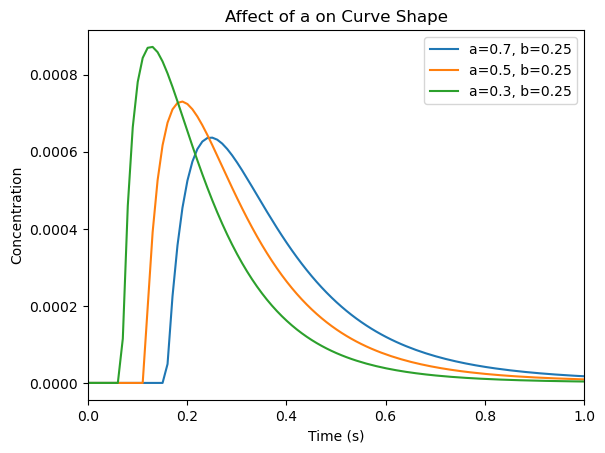

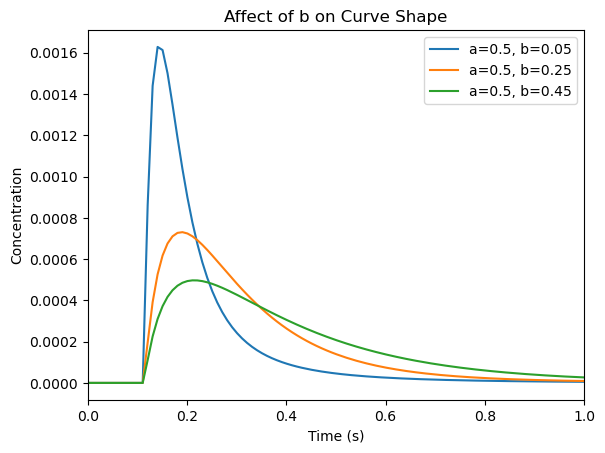

In [156]:
fig, ax = plt.subplots()
ax.plot(t, c1, label=f"a={param_dict['Set1'][0]}, b={param_dict['Set1'][1]}")
ax.plot(t, c2, label=f"a={param_dict['Set2'][0]}, b={param_dict['Set2'][1]}")
ax.plot(t, c3, label=f"a={param_dict['Set3'][0]}, b={param_dict['Set3'][1]}")
plt.title('Affect of a on Curve Shape')
plt.ylabel('Concentration')
plt.xlabel('Time (s)')
plt.xlim(0, 1)
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(t, c4, label=f"a={param_dict['Set4'][0]}, b={param_dict['Set4'][1]}")
ax.plot(t, c5, label=f"a={param_dict['Set5'][0]}, b={param_dict['Set5'][1]}")
ax.plot(t, c6, label=f"a={param_dict['Set6'][0]}, b={param_dict['Set6'][1]}")
plt.title('Affect of b on Curve Shape')
plt.ylabel('Concentration')
plt.xlabel('Time (s)')
plt.xlim(0, 1)
plt.legend()
plt.show()

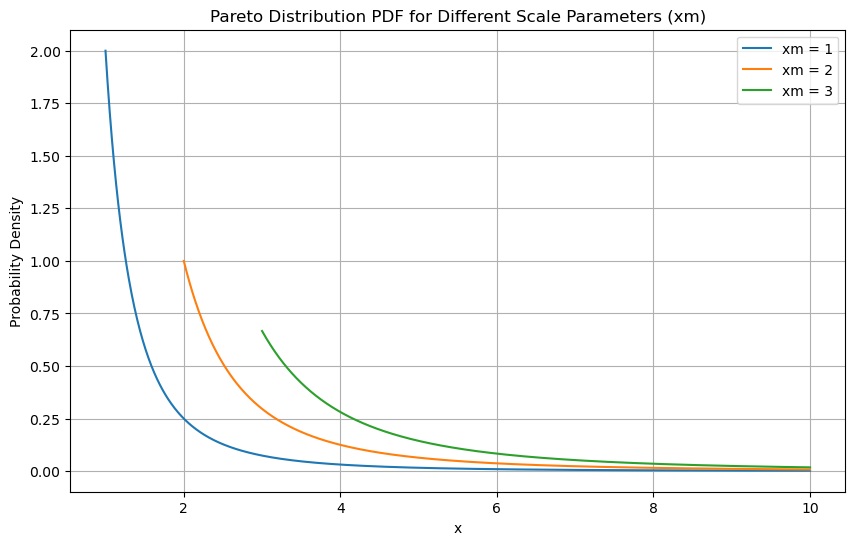

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Pareto distribution function
def pareto_pdf(x, xm, alpha):
    """Compute the PDF of the Pareto distribution."""
    return alpha * xm**alpha / x**(alpha + 1)

# Set up the range and parameters
x = np.linspace(1, 10, 1000)
xm_values = [1, 2, 3]  # Different scale parameters
alpha = 2  # Fixed shape parameter for simplicity

# Plot the Pareto PDF for different scale parameters
plt.figure(figsize=(10, 6))
for xm in xm_values:
    plt.plot(x[x >= xm], pareto_pdf(x[x >= xm], xm, alpha), label=f'xm = {xm}')

plt.title('Pareto Distribution PDF for Different Scale Parameters (xm)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()